<a href="https://colab.research.google.com/github/ti-molodykh/colab/blob/main/%D0%9C%D0%BE%D0%BB%D0%BE%D0%B4%D1%8B%D1%85_%D0%A2%D0%A1_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%A1%D0%98%D0%91%D0%98%D0%A0%D0%AC_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82_%22DA_%D0%A2%D0%B5%D0%BC%D0%B0_2_HH_ipynb%22%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Финальный проект: школа DA – анализ данных HeadHunter

---





В этом задании вам нужно будет проанализировать вакансии на сайте hh.ru.   
Для сбора данных рекомендуется использовать официальное API: https://dev.hh.ru/, ниже представлен готовый код для сбора данных. 

<img src="https://1ul.ru/upload/resize_image/publication/96872/960_0_3_HeadHunter.png" style="width:300px;">


**1. Сбор данных**

Для этого пункта вам обязательно нужно повторить: list, dict и pd.DataFrame.  
Соберите данные о вакансии Data Analyst по Москве в одну таблицу и подготовьте их для анализа (часто в индустрии подготовленные для анализа таблицы называют *витринами*). В ней должны быть (как минимум):
- название вакансии
- работодатель
- зарплатная вилка (обратите внимание на валюту, gross/net)
- станция метро (если указана)
- ссылка на вакансию
- опыт (если указан)
- требуемые навыки

Вам необходимо сложить эти данные в pandas Dataframe. Если что-то не получится – обращайтесь к ассистенту или куратору, с вами свяжутся и помогут :) 

Код ниже демонстрирует как подключиться к данным сайта Head Hunter и скачать их. В этом примере скачиваются данные о первых 10 вакансиях со словом analyst из Москвы с нулевой страницы выдачи (нумерация страниц начинается с нуля). 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline 

## Вариант 2

ССЫЛКА для скачивания https://drive.google.com/file/d/1h_gazdgE49UyUJLdwn6rdGJK53WKHvLQ/view?usp=sharing

In [ ]:
!pip install WordCloud # библеотека для рисования слов
!pip install folium #библиотека для рисования карты


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import requests  # библиотека для запросов на другие серверы, с ее помощью мы будем обращатсья к серверам head hunter, чтобы скачать данные
import json  # библиотека для работы с json-файлами (как словари в python, подробнее о json: https://tproger.ru/articles/chto-takoe-json-vvedenie/)
from time import sleep  # библиотека для того, чтобы делать временные паузы в коде. Будем использовать для того, чтобы не задудосить сервер HH слишком частыми запросами 
from tqdm import tqdm # progress bar
import folium # Построеник карты
#from folium.plugins import MarkerCluster # Маркеры на карте
#from folium.plugins import MousePosition
#from folium.features import DivIcon
from folium.plugins import HeatMap # Маркеры на карте
from folium import branca # Легенда на карте
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # Распределение слов на картинке


In [ ]:
# ПОЖАЛУЙСТА, НЕ ТРОГАЙТЕ КОД
'''
sleep_interval = 0.5  # размер паузы, которую мы будем делать на каждой итерации скачивания данных 

#Нормализуем адрес для поиска координат
def addrNorm(addr: str):
  res=addr
  if addr !=None:
    if '/' in addr:
      res=res.replace('/',' ')
    
    if 'микрорайон' in addr.lower():
      res_tmp=res
      res=''
      for i in res_tmp.split(','):
        if 'микрорайон' not in i.lower():
          res=res+' '+i      
  return res

#Создание dataframe и очистка
def loadDataFrame(vacancy: json):
  df = pd.DataFrame(vacancy,
                    columns = [
                                'name',
                                'skills_name',
                                'professional_roles',
                                'expirience_name',
                                'department_name',
                                'area_name',
                                'salary_from', 
                                'salary_to',
                                'salary_currency',
                                'type_name',
                                'address_raw',
                                'created_at',
                                'archived',
                                'insider_interview',
                                'url',
                                'alternate_url',
                                'employer_name',
                                'snippet_requirement',
                                'snippet_responsibility',
                                'contacts',
                                'schedule_name',
                                'working_days',
                                'working_time_intervals',
                                'working_time_modes',
                                'city',
                                'street',
                                'building',
                                'metro',
                                'district',
                                'coord_district',
                                'lat_district'
                                ])
  df.to_csv('da_hh_sibir_raw.csv')
# очистка данных 
  df['salary_from'] = df['salary_from'].fillna(df['salary_to'])
  df['salary_to'] = df['salary_to'].fillna(df['salary_from'])
  df = df.dropna(subset=['salary_from', 'salary_to'])
  df = df.dropna(subset=['address_raw'])
  df = df.dropna(subset=['lat_district'])
    
  df.to_csv('da_hh_sibir.csv')
  return df

#Получение id городов
def getIdCity(nameList: list) -> list:
  data_id = []
  i = 0
  idCountry= None
  URLCity = 'https://api.hh.ru/areas'
  req = requests.get(URLCity) #Запрос страницы
  while req.status_code!=200: #Если статус ответа не 200, делаем паузу и снова запрашиваем
      sleep(sleep_interval)
      req = requests.get(URLCity)
      i+=1
      if (i==11):
        print('Ошибка получения id страны - TimeOut')
  if i<11:
    data = json.loads(req.content.decode())
    for country in data:
      if country['name']=='Россия':
        idCountry=country['id']
        break
      else:
        continue
  if idCountry is not None:
    req = requests.get(URLCity+'/'+idCountry) #Запрос страницы
    i=0
    while req.status_code!=200: #Если статус ответа не 200, делаем паузу и снова запрашиваем
      sleep(sleep_interval)
      req = requests.get(+'/'+idCountry)
      i+=1
      if (i==11):
        print('Ошибка получения id городов - TimeOut')
    if i<11:
      data = json.loads(req.content.decode())
      data = data['areas']
    for city in data:
      for name in nameList:
        if name.upper() in city['name'].upper():
          data_id.append(city['id'])
          #По городу сразу запрашиваем список подгородов (пропустили проверки)
          req=requests.get(URLCity+'/'+city['id'])
          data_subcity=json.loads(req.content.decode())
          for subcity in data_subcity['areas']:
            data_id.append(str(subcity['id']))
        else:
          continue
  else:
     print('Ошибка получения id страны - Код не найден в возвращенном json')
  return data_id

#Сбор данных по вакансиям
if __name__== '__main__':
  
  URLVacancies = 'https://api.hh.ru/vacancies'  # URL для подключения к данным сайта Head Hunter 

  data_list = []  # переменная-список, в который мы будем складывать скачанные данные 
  N = 200 # количество страниц поисковой выдачи, данные с которых мы хотим скачать
  area_list=[]
  area_list.append(getIdCity(['Новосиб','Томск']))

  str_find='"аналитик данных" or "BI-аналитик" or "Бизнес аналитик" or data or analyst'
  # скачиваем данные
  for n in tqdm(range(N)):
    i=0
    params = {'text': str_find,  # параметр text, кладем сюда название вакансии 
            'area': area_list,  # параметр area, кладем сюда идентификатор города
            'page': n,  # параметр page, номер страницы поисковой выдачи по запросу из параметра text 
            'per_page': 10,  # параметр per_page, количество объектов на странице выдачи
            'only_with_salary': 'true',
            'period': 30,
            'premium': 'true',
            'salary': 1000
            #'search_field': ['name','description']
          }

    req = requests.get(URLVacancies, params) #Запрос страницы
    while req.status_code!=200: #Если статус ответа не 200, делаем паузу и снова запрашиваем
      sleep(sleep_interval)
      req = requests.get(URLVacancies, params)
      i+=1
      if (i==11):
        break
    if i<11: #Если пауза повторилась более 11 раз, значит данные не получены и делаем пропуск данных
      data = json.loads(req.content.decode('utf8'))
      for js in data['items']: #Разбор общей информации по вакансии
            if js['salary'] != None:
                salary_from = js['salary']['from']
                salary_to = js['salary']['to']
                salary_currency=js['salary']['currency']
            else:
                salary_from = None
                salary_to = None
                salary_currency=None
            if js['address'] != None:
                address_raw = js['address']['raw']
            else:
                address_raw = None
            if js['department']!=None:
                  department = js['department']['name']
            else:
                  department = None
                  
            #Запрашиваем подробности о вакансии
            try:
              req_dop = requests.get(js['url'])
              js_dop=json.loads(req_dop.content.decode('utf8'))
              skills=''
              for key_skill in js_dop['key_skills']:
                    skills=skills+key_skill['name']+', '
              prof=''
              for key_skill in js_dop['professional_roles']:
                    prof=prof+key_skill['name']+', '
              if js_dop['address']!=None:
                city=js_dop['address']['city']
                street=js_dop['address']['street']
                building=js_dop['address']['building']
                lat=js_dop['address']['lat']
                lng=js_dop['address']['lng']
                metro=''
                district=''
                
                #Получение координат района и названия района
                address_raw_norm=addrNorm(address_raw)
              # address_raw='Новосибирск Академика коптюга 4'
                req_district=requests.get(f'https://nominatim.openstreetmap.org/search/{address_raw_norm}?format=json&addressdetails=1&polygon_svg=1')
                js_district=json.loads(req_district.content.decode('utf8'))
                district_find=''
                lat_district=None
                lon_district=None
                if len(js_district)>0:
                  if js_district[0]['address']!=None:
                    if 'city' in js_district[0]['address']:
                      district_find=js_district[0]['address']['city']  
                    elif 'town' in js_district[0]['address']:
                      district_find=js_district[0]['address']['town']   
                    if 'suburb' in js_district[0]['address']:
                      district=js_district[0]['address']['suburb']
                      district_find=district_find+' '+district
                    if 'city_district' in js_district[0]['address']:
                      if len(district)>0:
                        district=district+','+js_district[0]['address']['city_district']
                        district_find=district_find+' '+js_district[0]['address']['city_district']
                      else:
                        district=js_district[0]['address']['city_district']
                        district_find=district_find+' '+js_district[0]['address']['city_district']
                
                #Координаты района
                if len(district_find)>0:
                  req_district_latlgn=requests.get(f'https://nominatim.openstreetmap.org/search/{district_find}?format=json&addressdetails=1&limit=1&polygon_svg=1')
                  js_district_latlgn=json.loads(req_district_latlgn.content.decode('utf8'))
                  if len(js_district_latlgn)>0:
                    if 'lat' in js_district_latlgn[0]:
                      lat_district=js_district_latlgn[0]['lat']
                    if 'lon' in js_district_latlgn[0]:
                      lon_district=js_district_latlgn[0]['lon']
                
                if js_dop['address']['metro_stations']!=None:
                  for metro_lines in js_dop['address']['metro_stations']:
                    if metro_lines['line_name'] not in metro: #Если в данных есть дубли, исключить
                      metro=metro+metro_lines['line_name']+','
              else:
                city=None
                street=None
                building=None
                metro=None
                district=None
                lat,lng=None,None
                lat_district, lon_district=None, None
              # создаем список вакансии
              data_list.append([
                      js['name'],
                      skills,
                      prof,
                      js_dop['experience']['name'],
                      department,
                      js['area']['name'],
                      salary_from, 
                      salary_to,
                      salary_currency,
                      js['type']['name'],
                      address_raw,
                      js['created_at'],
                      js['archived'],
                      js['insider_interview'],
                      js['url'],
                      js['alternate_url'],
                      js['employer']['name'],
                      js['snippet']['requirement'],
                      js['snippet']['responsibility'],
                      js['contacts'],
                      js['schedule']['name'],
                      js['working_days'],
                      js['working_time_intervals'],
                      js['working_time_modes'],
                      city,
                      street,
                      building,
                      metro,
                      district,
                      (lat_district, lon_district),
                      lat_district
                      ])
            except Exception:
                    print('Пропуск данных')
                    pass
#Создаем DataFrame и чистим данные
df=loadDataFrame(data_list)
'''

100%|██████████| 200/200 [09:23<00:00,  2.82s/it]


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving da_hh_sibir.csv to da_hh_sibir.csv


In [ ]:
# читаем файл csv
data = pd.read_csv("da_hh_sibir.csv", encoding='utf8')
data['skills_name']=data['skills_name'].str.rstrip(', ') # убрала последнюю запятую в колонке
data['professional_roles']=data['professional_roles'].str.rstrip(', ') # убрала последнюю запятую в колонке
data

,Unnamed: 0,name,skills_name,professional_roles,expirience_name,department_name,area_name,salary_from,salary_to,salary_currency,...,working_days,working_time_intervals,working_time_modes,city,street,building,metro,district,coord_district,lat_district
0,0,Бизнес-аналитик,"Бизнес-анализ, SQL, Аналитическое мышление, Ан...",Аналитик,От 1 года до 3 лет,NaN,Томск,100000.0,100000.0,RUR,...,[],[],[],Томск,проспект Ленина,60/1,NaN,Советский район,"('56.4738847', '85.0446606855598')",56.473885
1,1,Аналитик,"Анализ данных, Управленческая отчетность, Прог...",Аналитик,Нет опыта,NaN,Новосибирск,45000.0,50000.0,RUR,...,[],[],[],Новосибирск,Коммунистическая улица,11,NaN,Железнодорожный район,"('55.02810805', '82.899106524133')",55.028108
2,2,Бизнес-аналитик (системный аналитик),"Разработка технических заданий, Информационные...",Бизнес-аналитик,От 1 года до 3 лет,NaN,Новосибирск,48000.0,48000.0,RUR,...,[],[],[],Новосибирск,улица Максима Горького,24,NaN,Железнодорожный район,"('55.02810805', '82.899106524133')",55.028108
3,3,Бизнес-аналитик,"Анализ рынка, SQL, ABC-анализ, Power BI, Power...","BI-аналитик, аналитик данных",От 1 года до 3 лет,NaN,Новосибирск,90000.0,90000.0,RUR,...,[],[],[],Новосибирск,"Кировский район, Северный проезд",11,"Ленинская,",Кировский район,"('54.965621999999996', '82.92359462895085')",54.965622
4,4,Бизнес-аналитик,"Разработка инструкций, Многозадачность, Подгот...",Аналитик,От 1 года до 3 лет,NaN,Томск,40000.0,60000.0,RUR,...,[],[],[],Томск,Заливная улица,1б,NaN,Советский район,"('56.4738847', '85.0446606855598')",56.473885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,697,Региональный торговый представитель,"Продажи через дистрибьюторов, работа с текущей...",Торговый представитель,От 1 года до 3 лет,NaN,Новосибирск,90000.0,90000.0,RUR,...,[],[],[],Новосибирск,улица Петухова,71А,"Ленинская,",Кировский район,"('54.965621999999996', '82.92359462895085')",54.965622
391,701,Руководитель филиала,"Управление продажами, Планирование продаж, Пря...",Руководитель отдела продаж,От 1 года до 3 лет,NaN,Новосибирск,150000.0,150000.0,RUR,...,[],[],[],Новосибирск,улица Петухова,71А,"Ленинская,",Кировский район,"('54.965621999999996', '82.92359462895085')",54.965622
392,702,Руководитель отдела продаж (РОП),"Активные продажи, Прямые продажи, Обучение пер...",Руководитель отдела продаж,От 1 года до 3 лет,NaN,Новосибирск,120000.0,250000.0,RUR,...,[],[],[],Новосибирск,Советская улица,23,"Ленинская,",Железнодорожный район,"('55.02810805', '82.899106524133')",55.028108
393,703,JavaScript разработчик на low-код платформу (M...,"JavaScript, UML, HTML, Управление проектами, CSS","Программист, разработчик",От 1 года до 3 лет,NaN,Новосибирск,80000.0,80000.0,RUR,...,[],[],[],Новосибирск,Октябрьская магистраль,4,"Ленинская,",Центральный район,"('55.0334735', '82.92811946313839')",55.033473


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              395 non-null    int64  
 1   name                    395 non-null    object 
 2   skills_name             343 non-null    object 
 3   professional_roles      395 non-null    object 
 4   expirience_name         395 non-null    object 
 5   department_name         42 non-null     object 
 6   area_name               395 non-null    object 
 7   salary_from             395 non-null    float64
 8   salary_to               395 non-null    float64
 9   salary_currency         395 non-null    object 
 10  type_name               395 non-null    object 
 11  address_raw             395 non-null    object 
 12  created_at              395 non-null    object 
 13  archived                395 non-null    bool   
 14  insider_interview       0 non-null      fl

**2. Анализ и визуализация данных**

In [ ]:
# удаление дупликатов
data.drop_duplicates(inplace = True)
data

,Unnamed: 0,name,skills_name,professional_roles,expirience_name,department_name,area_name,salary_from,salary_to,salary_currency,...,working_days,working_time_intervals,working_time_modes,city,street,building,metro,district,coord_district,lat_district
0,0,Бизнес-аналитик,"Бизнес-анализ, SQL, Аналитическое мышление, Ан...",Аналитик,От 1 года до 3 лет,NaN,Томск,100000.0,100000.0,RUR,...,[],[],[],Томск,проспект Ленина,60/1,NaN,Советский район,"('56.4738847', '85.0446606855598')",56.473885
1,1,Аналитик,"Анализ данных, Управленческая отчетность, Прог...",Аналитик,Нет опыта,NaN,Новосибирск,45000.0,50000.0,RUR,...,[],[],[],Новосибирск,Коммунистическая улица,11,NaN,Железнодорожный район,"('55.02810805', '82.899106524133')",55.028108
2,2,Бизнес-аналитик (системный аналитик),"Разработка технических заданий, Информационные...",Бизнес-аналитик,От 1 года до 3 лет,NaN,Новосибирск,48000.0,48000.0,RUR,...,[],[],[],Новосибирск,улица Максима Горького,24,NaN,Железнодорожный район,"('55.02810805', '82.899106524133')",55.028108
3,3,Бизнес-аналитик,"Анализ рынка, SQL, ABC-анализ, Power BI, Power...","BI-аналитик, аналитик данных",От 1 года до 3 лет,NaN,Новосибирск,90000.0,90000.0,RUR,...,[],[],[],Новосибирск,"Кировский район, Северный проезд",11,"Ленинская,",Кировский район,"('54.965621999999996', '82.92359462895085')",54.965622
4,4,Бизнес-аналитик,"Разработка инструкций, Многозадачность, Подгот...",Аналитик,От 1 года до 3 лет,NaN,Томск,40000.0,60000.0,RUR,...,[],[],[],Томск,Заливная улица,1б,NaN,Советский район,"('56.4738847', '85.0446606855598')",56.473885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,697,Региональный торговый представитель,"Продажи через дистрибьюторов, работа с текущей...",Торговый представитель,От 1 года до 3 лет,NaN,Новосибирск,90000.0,90000.0,RUR,...,[],[],[],Новосибирск,улица Петухова,71А,"Ленинская,",Кировский район,"('54.965621999999996', '82.92359462895085')",54.965622
391,701,Руководитель филиала,"Управление продажами, Планирование продаж, Пря...",Руководитель отдела продаж,От 1 года до 3 лет,NaN,Новосибирск,150000.0,150000.0,RUR,...,[],[],[],Новосибирск,улица Петухова,71А,"Ленинская,",Кировский район,"('54.965621999999996', '82.92359462895085')",54.965622
392,702,Руководитель отдела продаж (РОП),"Активные продажи, Прямые продажи, Обучение пер...",Руководитель отдела продаж,От 1 года до 3 лет,NaN,Новосибирск,120000.0,250000.0,RUR,...,[],[],[],Новосибирск,Советская улица,23,"Ленинская,",Железнодорожный район,"('55.02810805', '82.899106524133')",55.028108
393,703,JavaScript разработчик на low-код платформу (M...,"JavaScript, UML, HTML, Управление проектами, CSS","Программист, разработчик",От 1 года до 3 лет,NaN,Новосибирск,80000.0,80000.0,RUR,...,[],[],[],Новосибирск,Октябрьская магистраль,4,"Ленинская,",Центральный район,"('55.0334735', '82.92811946313839')",55.033473


Дубликатов нет.

In [ ]:
#заполним все пропуски одним и тем же значением "unknown"
data.fillna("unknown")

,Unnamed: 0,name,skills_name,professional_roles,expirience_name,department_name,area_name,salary_from,salary_to,salary_currency,...,working_days,working_time_intervals,working_time_modes,city,street,building,metro,district,coord_district,lat_district
0,0,Бизнес-аналитик,"Бизнес-анализ, SQL, Аналитическое мышление, Ан...",Аналитик,От 1 года до 3 лет,unknown,Томск,100000.0,100000.0,RUR,...,[],[],[],Томск,проспект Ленина,60/1,unknown,Советский район,"('56.4738847', '85.0446606855598')",56.473885
1,1,Аналитик,"Анализ данных, Управленческая отчетность, Прог...",Аналитик,Нет опыта,unknown,Новосибирск,45000.0,50000.0,RUR,...,[],[],[],Новосибирск,Коммунистическая улица,11,unknown,Железнодорожный район,"('55.02810805', '82.899106524133')",55.028108
2,2,Бизнес-аналитик (системный аналитик),"Разработка технических заданий, Информационные...",Бизнес-аналитик,От 1 года до 3 лет,unknown,Новосибирск,48000.0,48000.0,RUR,...,[],[],[],Новосибирск,улица Максима Горького,24,unknown,Железнодорожный район,"('55.02810805', '82.899106524133')",55.028108
3,3,Бизнес-аналитик,"Анализ рынка, SQL, ABC-анализ, Power BI, Power...","BI-аналитик, аналитик данных",От 1 года до 3 лет,unknown,Новосибирск,90000.0,90000.0,RUR,...,[],[],[],Новосибирск,"Кировский район, Северный проезд",11,"Ленинская,",Кировский район,"('54.965621999999996', '82.92359462895085')",54.965622
4,4,Бизнес-аналитик,"Разработка инструкций, Многозадачность, Подгот...",Аналитик,От 1 года до 3 лет,unknown,Томск,40000.0,60000.0,RUR,...,[],[],[],Томск,Заливная улица,1б,unknown,Советский район,"('56.4738847', '85.0446606855598')",56.473885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,697,Региональный торговый представитель,"Продажи через дистрибьюторов, работа с текущей...",Торговый представитель,От 1 года до 3 лет,unknown,Новосибирск,90000.0,90000.0,RUR,...,[],[],[],Новосибирск,улица Петухова,71А,"Ленинская,",Кировский район,"('54.965621999999996', '82.92359462895085')",54.965622
391,701,Руководитель филиала,"Управление продажами, Планирование продаж, Пря...",Руководитель отдела продаж,От 1 года до 3 лет,unknown,Новосибирск,150000.0,150000.0,RUR,...,[],[],[],Новосибирск,улица Петухова,71А,"Ленинская,",Кировский район,"('54.965621999999996', '82.92359462895085')",54.965622
392,702,Руководитель отдела продаж (РОП),"Активные продажи, Прямые продажи, Обучение пер...",Руководитель отдела продаж,От 1 года до 3 лет,unknown,Новосибирск,120000.0,250000.0,RUR,...,[],[],[],Новосибирск,Советская улица,23,"Ленинская,",Железнодорожный район,"('55.02810805', '82.899106524133')",55.028108
393,703,JavaScript разработчик на low-код платформу (M...,"JavaScript, UML, HTML, Управление проектами, CSS","Программист, разработчик",От 1 года до 3 лет,unknown,Новосибирск,80000.0,80000.0,RUR,...,[],[],[],Новосибирск,Октябрьская магистраль,4,"Ленинская,",Центральный район,"('55.0334735', '82.92811946313839')",55.033473


Проведите исследование получившихся данных. Прежде всего убедитесь, что ваши данные чистые.  
Убедитесь, что вы проделали следующее:
- удаление дупликатов
- предобработка пропусков (либо их удаление, либо заполнение значением "unknown")


Ответьте не следующие вопросы:  
- сколько сейчас доступно вакансий по вашему запросу?
- выделяются ли среди вакансий какие-то группы? Например: бизнес-аналитик, BI аналитик, продуктовый аналитик 
- какие группы вакансий самые популярные?
- какая средняя заработная плата? А медианная? Не забудьте построить гистограмму распределения
- какие ключевые навыки требуются для данной вакансии?
- какой опыт требуется для данной вакансии?
- какие работодатели в топе? 
- в каком районе Москвы данная вакансия пользуется наибольшим спросом? А наименьшим? 

Не забудьте про визуализацию - для этого либо используйтре библиотеки python, либо загрузите скачанные данные в BI-систему Yandex Datalens. Постройте следующие графики:
- гистограмма распределения заработной платы
- зависимость количества вакансий от группы и навыка
- зависимость средней заработной платы от требуемых навыков
- распределение средней заработной платы по карте Москвы (опционально)
- распределение спроса на вакансию по карте Москвы (опционально)

Для построения последних двух графиков вам могут понадобиться [внешние данные](http://www.lovrikinfo.ru/metrogps.php)


Какие выводы можно сделать из построенных графиков?

In [ ]:
# Общее количество доступных для запроса вакансии 
vacancy=data['name'].value_counts()
vacancy.sum()

395

Text(0, 0.5, 'Количество')

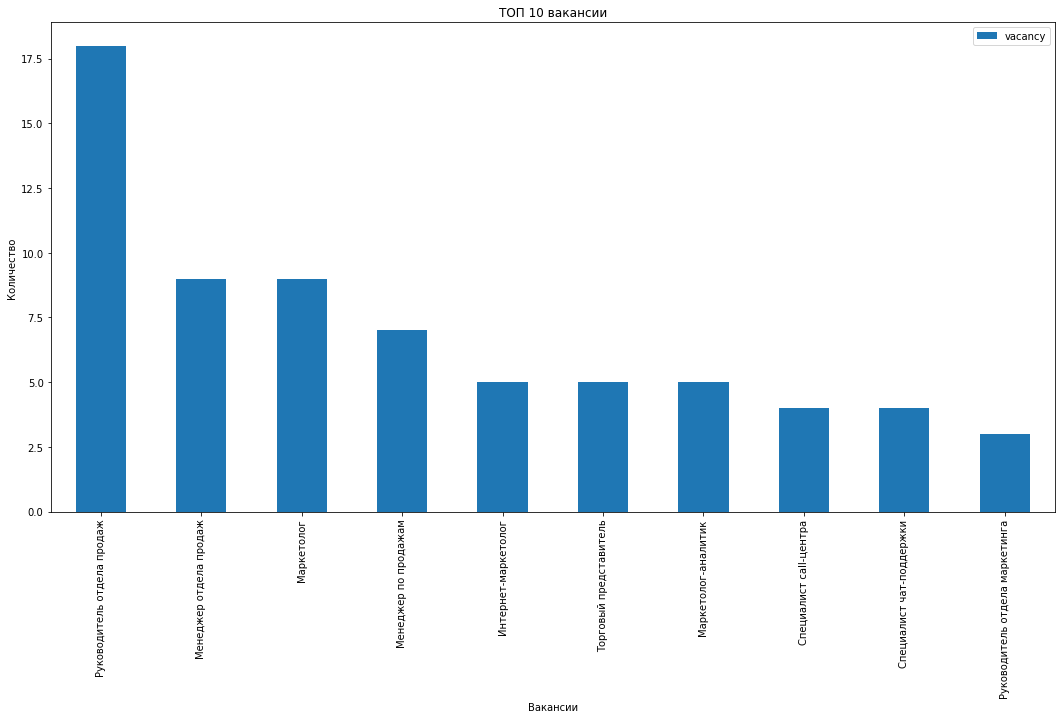

In [ ]:
# 1 сколько сейчас доступно вакансий по вашему запросу?
# топ 30 вакансии
plt.figure(figsize=(18, 9))
vacancy=data['name'].value_counts()
countrat=vacancy.count()
#plt.title("Количество вакансий - \n"+str(countrat), color='black')
plt.title("ТОП 10 вакансии", color='black')
vacancy.sort_values(ascending=False).head(10).plot(kind='bar')
plt.xlabel('Вакансии')
plt.legend(['vacancy'])
plt.ylabel('Количество')


In [ ]:
#  топ 30 вакансии
vacancy=data['name'].value_counts()
vacancy.sort_values(ascending=False).head(30)



Руководитель отдела продаж                 18
Менеджер отдела продаж                      9
Маркетолог                                  9
Менеджер по продажам                        7
Интернет-маркетолог                         5
Торговый представитель                      5
Маркетолог-аналитик                         5
Специалист call-центра                      4
Специалист чат-поддержки                    4
Руководитель отдела маркетинга              3
Экономист-аналитик                          3
Аналитик                                    3
Бизнес-аналитик                             3
Менеджер по маркетинговым исследованиям     3
Экономист                                   3
Менеджер по работе с клиентами              3
Специалист по подбору персонала             3
Системный аналитик                          3
Специалист контакт-центра                   2
Менеджер по оптовым продажам                2
Менеджер проектов                           2
Аналитик бизнес-процессов         

In [ ]:
vacancy.sort_values(ascending=False).head(10).to_excel('vacancy12.xlsx')

**ВЫВОД**  Всего у нас доступно 395 вакансии. 
Из них выделяем различных  - 304 вакансии. 
На Гистограмме выведены ТОП 30 самых распространенных  вакансии. 
Так наиболее часто встречаются: 
Руководитель отдела продаж (18),  
Маркетолог (9),
Менеджер отдела продаж (9),
Менеджер по продажам (7), Интернет-маркетолог (5),
Торговый представитель (5),
Маркетолог-аналитик (5). Исследуемая вакансия “Аналитик” не попала в ТОП30, поэтому проведем более детальный анализ


In [ ]:
import matplotlib.pyplot as plt

#from matplotlib.colors import LinearSegmentedColormap


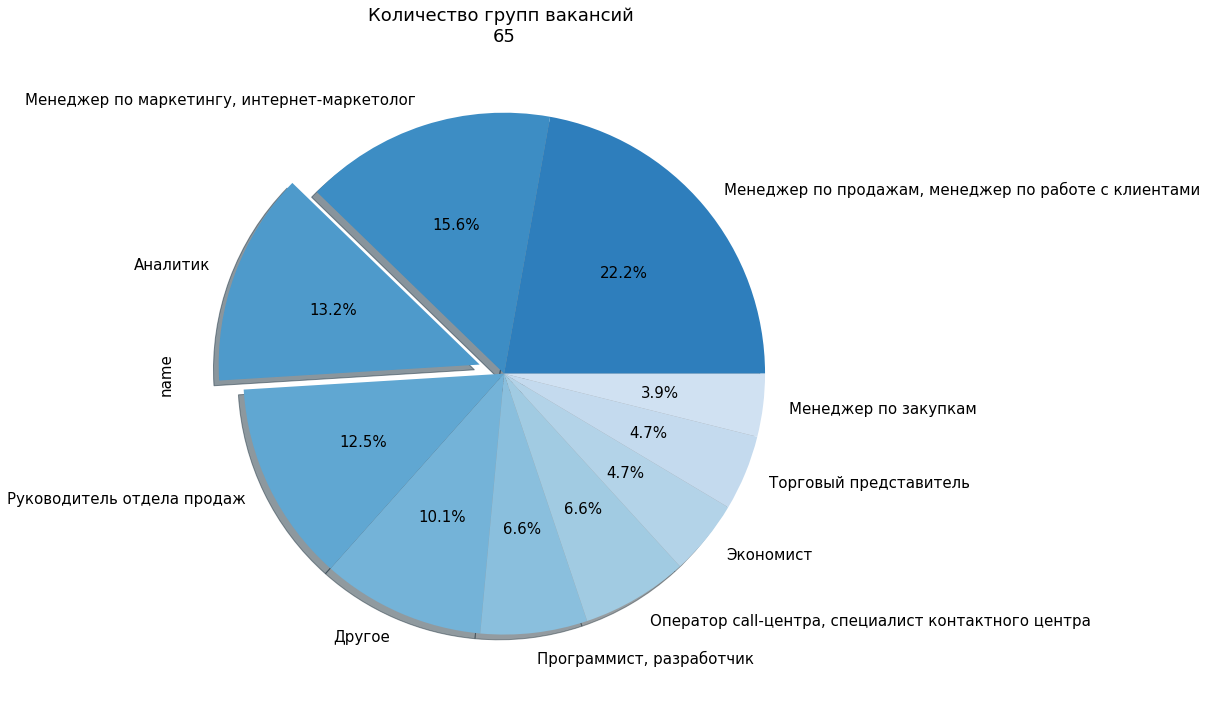

In [ ]:
# выделяются ли среди вакансий какие-то группы? Например: бизнес-аналитик, BI аналитик, продуктовый аналитик 
# ТОП10 популярных групп вакансии
plt.figure(figsize=(12, 12))
vacancy=data.groupby('professional_roles')['name'].count()
countrat1=vacancy.count()
plt.title("Количество групп вакансий \n"+str(countrat1), color='black')
#colors = ['indigo', 'darkblue', 'darkgrey', 'steelblue', 'silver', 'darkturquoise', 'turquoise', 'grey', 'blue', 'plum', 'lavender']
colors = plt.get_cmap('Blues')(np.linspace(0.7, 0.2, len(vacancy.sort_values(ascending=False).head(10))))

explode = (0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0)
 
#fig, ax = plt.subplots()
vacancy.sort_values(ascending=False).head(10).plot(kind= 'pie', explode = explode,  autopct='%1.1f%%',
        shadow=True, colors = colors)
plt.rc('font', size= 15)
plt.show()


In [ ]:
data.groupby('professional_roles')['name'].count().sort_values(ascending=False).head(15)

professional_roles
Менеджер по продажам, менеджер по работе с клиентами    57
Менеджер по маркетингу, интернет-маркетолог             40
Аналитик                                                34
Руководитель отдела продаж                              32
Другое                                                  26
Программист, разработчик                                17
Оператор call-центра, специалист контактного центра     17
Экономист                                               12
Торговый представитель                                  12
Менеджер по закупкам                                    10
SMM-менеджер, контент-менеджер                           9
Специалист по подбору персонала                          9
Коммерческий директор (CCO)                              7
Специалист технической поддержки                         7
Директор по маркетингу и PR (CMO)                        7
Name: name, dtype: int64

In [ ]:
#какие группы вакансий самые популярные, содержащих слово 'аналитик'? зависимость количества вакансий от группы и навыка
data_group=data[data['name'].str.contains('Аналитик')]
data_group.groupby('professional_roles')['name'].count().sort_values(ascending=False)

professional_roles
Аналитик                                                14
Другое                                                   4
Программист, разработчик                                 3
BI-аналитик, аналитик данных                             1
Менеджер по продажам, менеджер по работе с клиентами     1
Специалист по информационной безопасности                1
Name: name, dtype: int64

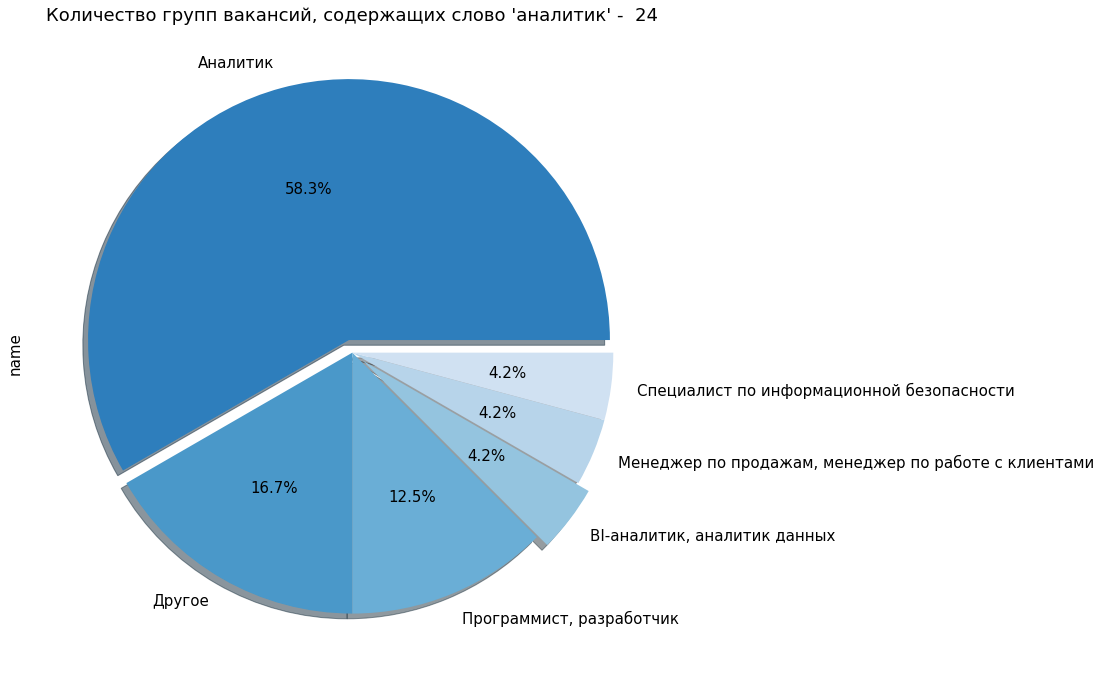

In [ ]:
plt.figure(figsize=(12, 12))
countrat2=data_group.groupby('professional_roles')['name'].value_counts().sum()
plt.title("Количество групп вакансий, содержащих слово 'аналитик' -  " + str(countrat2), color='black')
vacancy_group=data_group.groupby('professional_roles')['name'].count()
colors = plt.get_cmap('Blues')(np.linspace(0.7, 0.2, len(vacancy_group.sort_values(ascending=False))))
explode = (0.05, 0, 0, 0.05, 0, 0)

vacancy_group.sort_values(ascending=False).plot(kind= 'pie',  explode = explode, autopct='%.1f%%',  shadow=True, colors = colors)
plt.rc('font', size= 15)
plt.show()

**ВЫВОД**
 Всего групп вакансий 65, а групп в которых встречается слово "аналитик" - 24, т.е. это около 37%. Из них  самая большая группа вакансии - Аналитик (58, 3%) , наименьшая группа BI-аналитик, аналитик данных - 4,2%. Считаем результат поиска вакансии, по выбранным ключевым словам, на сайте hh релевантным.

In [ ]:
# какая средняя заработная плата? А медианная? Не забудьте построить гистограмму распределения
# гистограмма распределения заработной платы

In [ ]:
data['salary_mean'] = round((data['salary_from'] + data['salary_to']) / 2)
data.head(5)

,Unnamed: 0,name,skills_name,professional_roles,expirience_name,department_name,area_name,salary_from,salary_to,salary_currency,...,working_time_intervals,working_time_modes,city,street,building,metro,district,coord_district,lat_district,salary_mean
0,0,Бизнес-аналитик,"Бизнес-анализ, SQL, Аналитическое мышление, Ан...",Аналитик,От 1 года до 3 лет,NaN,Томск,100000.0,100000.0,RUR,...,[],[],Томск,проспект Ленина,60/1,NaN,Советский район,"('56.4738847', '85.0446606855598')",56.473885,100000.0
1,1,Аналитик,"Анализ данных, Управленческая отчетность, Прог...",Аналитик,Нет опыта,NaN,Новосибирск,45000.0,50000.0,RUR,...,[],[],Новосибирск,Коммунистическая улица,11,NaN,Железнодорожный район,"('55.02810805', '82.899106524133')",55.028108,47500.0
2,2,Бизнес-аналитик (системный аналитик),"Разработка технических заданий, Информационные...",Бизнес-аналитик,От 1 года до 3 лет,NaN,Новосибирск,48000.0,48000.0,RUR,...,[],[],Новосибирск,улица Максима Горького,24,NaN,Железнодорожный район,"('55.02810805', '82.899106524133')",55.028108,48000.0
3,3,Бизнес-аналитик,"Анализ рынка, SQL, ABC-анализ, Power BI, Power...","BI-аналитик, аналитик данных",От 1 года до 3 лет,NaN,Новосибирск,90000.0,90000.0,RUR,...,[],[],Новосибирск,"Кировский район, Северный проезд",11,"Ленинская,",Кировский район,"('54.965621999999996', '82.92359462895085')",54.965622,90000.0
4,4,Бизнес-аналитик,"Разработка инструкций, Многозадачность, Подгот...",Аналитик,От 1 года до 3 лет,NaN,Томск,40000.0,60000.0,RUR,...,[],[],Томск,Заливная улица,1б,NaN,Советский район,"('56.4738847', '85.0446606855598')",56.473885,50000.0


In [ ]:
mean_salary=data.groupby('professional_roles')['salary_mean'].mean().round(2)
mean_salary.sort_values(ascending=False).head(30)

professional_roles
Инженер-конструктор, инженер-проектировщик              202500.00
Операционный директор (COO)                             171666.67
DevOps-инженер                                          140000.00
Коммерческий директор (CCO)                             135714.29
Медицинский представитель                               130000.00
Директор по персоналу (HRD)                             130000.00
Генеральный директор, исполнительный директор (CEO)     125000.00
Программист, разработчик                                123529.41
Директор по маркетингу и PR (CMO)                       118571.43
Руководитель отдела продаж                              115937.50
Руководитель проектов                                   108650.00
Руководитель группы разработки                          105000.00
Брокер                                                  100000.00
Специалист по информационной безопасности                90000.00
Финансовый аналитик, инвестиционный аналитик             

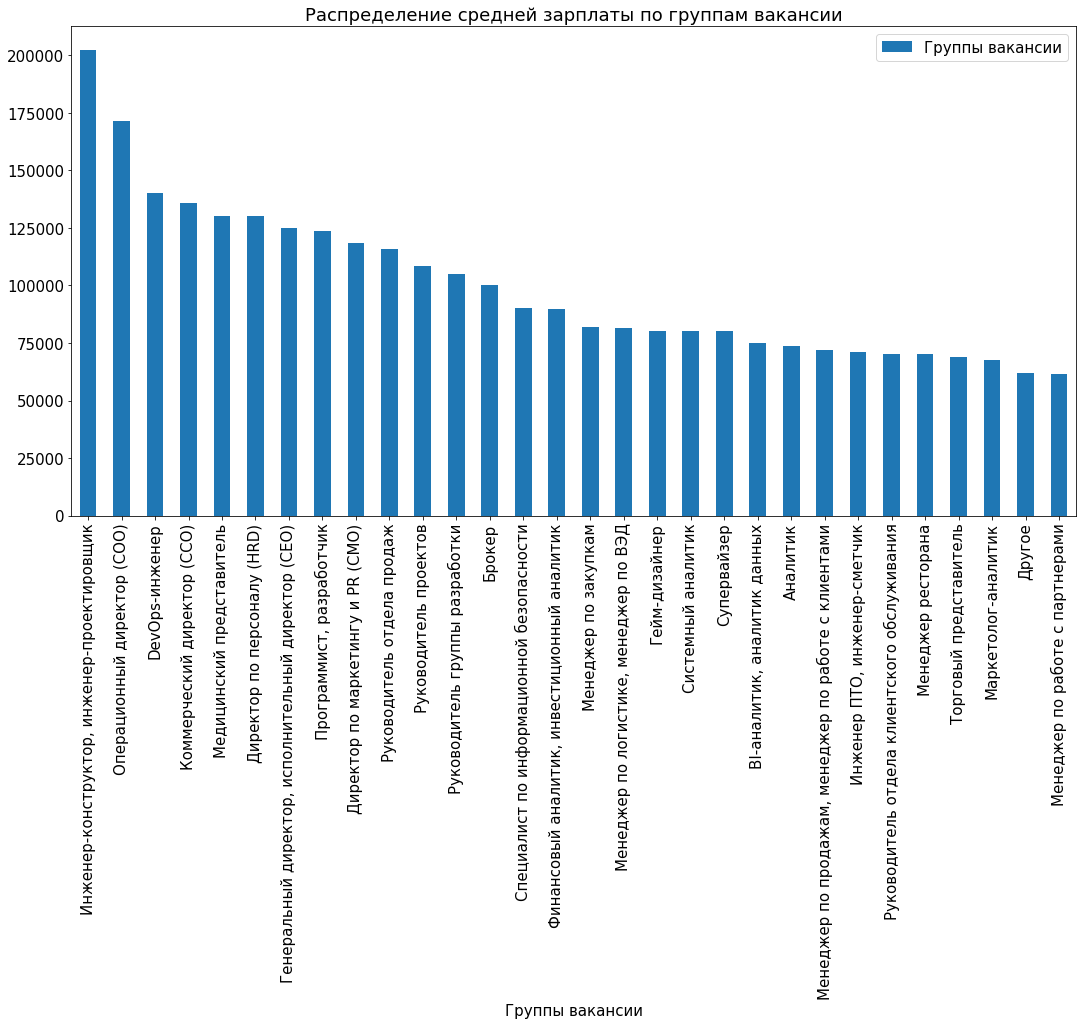

In [ ]:
plt.figure(figsize=(18, 9))
mean_salary=data.groupby('professional_roles')['salary_mean'].mean().round(2)
plt.title("Распределение средней зарплаты по группам вакансии", color='black')
mean_salary.sort_values(ascending=False).head(30).plot(kind='bar')
plt.xlabel('Группы вакансии')
plt.legend(['Группы вакансии'])

In [ ]:
# Медиана 
median_salary=data.groupby('professional_roles')['salary_mean'].median().round(2)
median_salary.sort_values(ascending=False).head(30)


professional_roles
Инженер-конструктор, инженер-проектировщик              202500.0
Коммерческий директор (CCO)                             150000.0
DevOps-инженер                                          140000.0
Директор по персоналу (HRD)                             130000.0
Медицинский представитель                               130000.0
Генеральный директор, исполнительный директор (CEO)     125000.0
Программист, разработчик                                120000.0
Операционный директор (COO)                             115000.0
Руководитель группы разработки                          105000.0
Директор по маркетингу и PR (CMO)                       100000.0
Брокер                                                  100000.0
Руководитель проектов                                   100000.0
Финансовый аналитик, инвестиционный аналитик            100000.0
Руководитель отдела продаж                              100000.0
Специалист по информационной безопасности                90000.0
Гейм-д

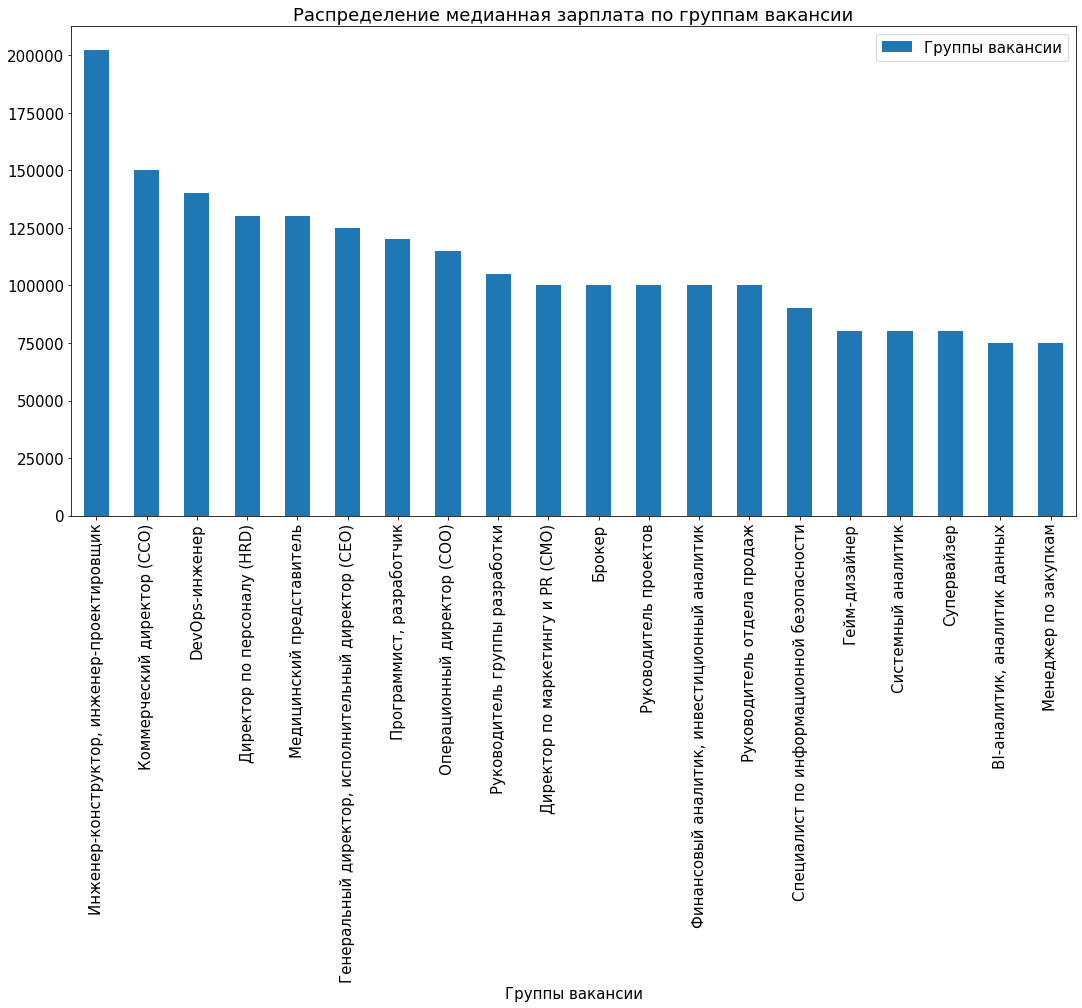

In [ ]:
plt.figure(figsize=(18, 9))
median_salary=data.groupby('professional_roles')['salary_mean'].median().round(2)
plt.title("Распределение медианная зарплата по группам вакансии", color='black')
median_salary.sort_values(ascending=False).head(20).plot(kind='bar')
plt.xlabel('Группы вакансии')
plt.legend(['Группы вакансии'])

In [ ]:
statistics_salary=data.groupby('professional_roles')['salary_mean'].describe().round(2)
statistics_salary.sort_values(by=['std', 'mean', 'min', 'max', '50%'], ascending=False).head(30)

,count,mean,std,min,25%,50%,75%,max
professional_roles,,,,,,,,
Операционный директор (COO),3.0,171666.67,111392.70,100000.0,107500.0,115000.0,207500.0,300000.0
Руководитель проектов,5.0,108650.00,58237.55,50000.0,70000.0,100000.0,123250.0,200000.0
Руководитель отдела продаж,32.0,115937.50,56174.23,50000.0,80000.0,100000.0,138750.0,325000.0
Аналитик,34.0,73801.47,52114.67,15000.0,45000.0,57500.0,88750.0,250000.0
"Программист, разработчик",17.0,123529.41,51864.15,35000.0,100000.0,120000.0,175000.0,200000.0
Директор по маркетингу и PR (CMO),7.0,118571.43,51777.91,60000.0,80000.0,100000.0,155000.0,200000.0
Коммерческий директор (CCO),7.0,135714.29,47559.49,80000.0,100000.0,150000.0,150000.0,220000.0
Методист,2.0,54750.00,31466.25,32500.0,43625.0,54750.0,65875.0,77000.0
Другое,26.0,61961.54,30551.24,22000.0,45000.0,50500.0,66875.0,150000.0


**ВЫВОД** Медиана и средняя зарплата практически идентичны.  По группе «аналитик» максимальная заработная плата 250 тысяч рублей, средняя 73801.47, медианная - 57 500, минимальная 15000.0. 
По некоторым вакансиям существует пространство для роста, т.е. разброс в заработной плате - от и до. Минимальная и максимальная заработная плата по одной вакансии может разниться в 2-3 раза.  Так, например, минимум предлагаемый руководителю международных продаж равен 150 тысячам. Успешный руководитель может повысить свою заработную плату до 500 тысяч. 

Text(0.5, 1.0, 'Требуемые навыки')

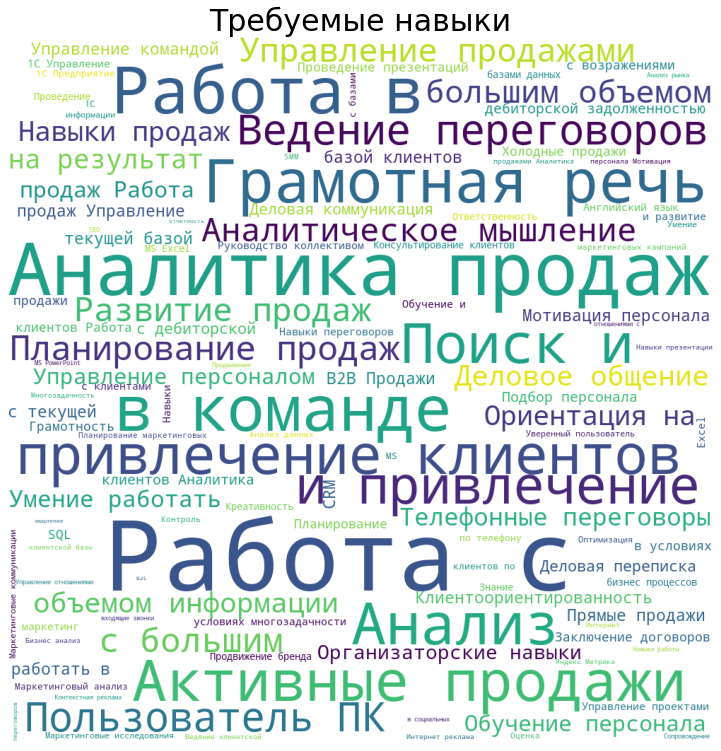

In [ ]:
#data['skills_name']
# какие ключевые навыки требуются для данной вакансии?
df = data.dropna(subset=['skills_name']) #Удалила все пустые строки в skills_name, библиотека работы со словами без этого не работает
plt.rcParams['figure.figsize'] = (13, 13)
wordcloud = WordCloud(stopwords=STOPWORDS,background_color = 'white', width = 1000,  height = 1000, max_words = 121).generate(' '.join(df['skills_name']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Требуемые навыки',fontsize = 30)

**ВЫВОД** На данном рисунке мы наглядно можем увидеть какие чаще требования предъявляют работодатели к навыкам соискателей. 
Более детально на навыках, опыте и  зависимости оплаты соискателя от навыка и опыта мы рассмотрим дальше. 


In [ ]:
# из колонки навыки, получаем отдельные названия навыков
import collections # Подсчет слов в списке и группировка
resWrite=data['skills_name'].str.split(', ').dropna()
res_list=[]
for name_skills in resWrite.values:
  if len(name_skills[0])>0:
    for skill in name_skills:
      res_list.append(skill)
resWrite = collections.Counter(res_list) # группировка и подсчет навыков
resWrite.most_common(40)

[('Аналитика продаж', 97),
 ('Грамотная речь', 63),
 ('Активные продажи', 57),
 ('Работа в команде', 56),
 ('Поиск и привлечение клиентов', 52),
 ('Ведение переговоров', 50),
 ('Планирование продаж', 41),
 ('Управление продажами', 40),
 ('Развитие продаж', 40),
 ('Аналитическое мышление', 38),
 ('Деловое общение', 37),
 ('Работа с большим объемом информации', 36),
 ('Навыки продаж', 35),
 ('Ориентация на результат', 33),
 ('Клиентоориентированность', 33),
 ('Телефонные переговоры', 33),
 ('Обучение персонала', 30),
 ('Организаторские навыки', 29),
 ('Управление командой', 28),
 ('Пользователь ПК', 27),
 ('B2B Продажи', 26),
 ('Прямые продажи', 26),
 ('Мотивация персонала', 25),
 ('работа с текущей базой клиентов', 25),
 ('Управление персоналом', 25),
 ('Грамотность', 24),
 ('Деловая переписка', 24),
 ('Деловая коммуникация', 24),
 ('CRM', 23),
 ('Работа с дебиторской задолженностью', 23),
 ('Проведение презентаций', 21),
 ('Холодные продажи', 20),
 ('Заключение договоров', 20),
 ('Подб

In [ ]:
 # из словаря получаем новый dataFrame 
 skills_df=pd.DataFrame(resWrite.items(), columns=['Skill', 'Value'])
 skills_df.set_index('Skill').sort_values(by='Value',ascending=False).head(40)


,Value
Skill,
Аналитика продаж,97
Грамотная речь,63
Активные продажи,57
Работа в команде,56
Поиск и привлечение клиентов,52
Ведение переговоров,50
Планирование продаж,41
Управление продажами,40
Развитие продаж,40


In [ ]:
skills_df.set_index('Skill').sort_values(by='Value',ascending=False).head(10).to_excel('10skills.xlsx')

In [ ]:
 #Python
data_Python =skills_df[(skills_df['Skill']=='Python')]
data_Python

,Skill,Value
24,Python,6


<Figure size 1440x720 with 0 Axes>

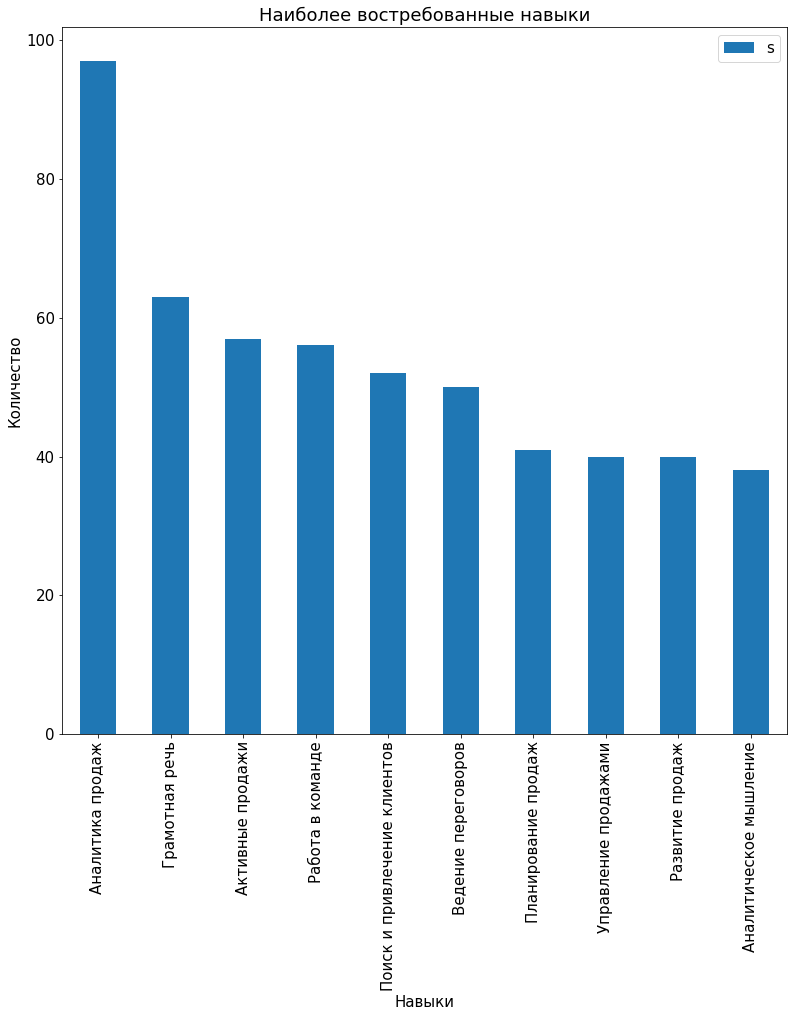

In [ ]:
plt.figure(figsize=(20, 10))
skills_df=pd.DataFrame(resWrite.items(), columns=['Skill', 'Value'])
skills_df=skills_df.set_index('Skill')
#plt.figure(figsize=(20, 15))
skills_df.sort_values(by='Value',ascending=False).head(10).plot(kind='bar')
plt.xlabel('Навыки')
plt.ylabel('Количество')
plt.legend('skills')
plt.title('Наиболее востребованные навыки')
plt.show()


**ВЫВОД** Самый востребованный навык - аналитика продаж, 97 вакансий или четверть от всех вакансий. Так же выделим такие навыки как:
Грамотная речь, Активные продажи, Работа в команде, Поиск и привлечение клиентов, Ведение переговоров, Планирование продаж, Аналитическое мышление. Реже: SQL, ABC-анализ, Power BI. И еще меньше Pathon - 6 раз.

In [ ]:
#зависимость средней заработной платы от требуемых навыков


**ВЫВОД**

In [ ]:
# какой опыт требуется для данной вакансии?
data.expirience_name.value_counts()

От 1 года до 3 лет    238
От 3 до 6 лет          78
Нет опыта              71
Более 6 лет             8
Name: expirience_name, dtype: int64

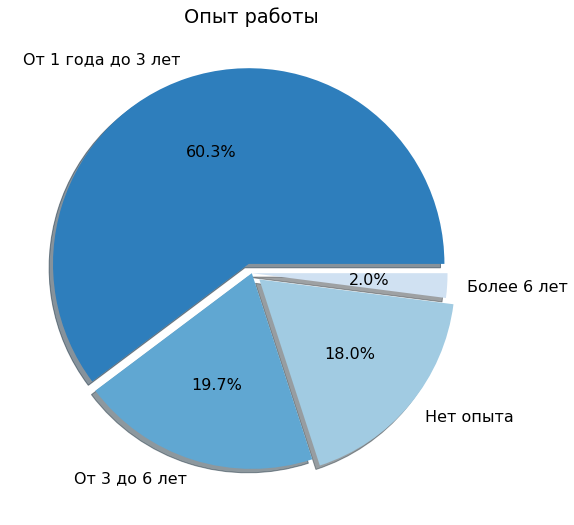

In [ ]:
plt.figure(figsize=(9,9))
plt.rc('font', size= 16)
exp = (0.05, 0, 0.05, 0)
colors = plt.get_cmap('Blues')(np.linspace(0.7, 0.2, len(data.expirience_name.value_counts())))
plt.title("Опыт работы")
data.expirience_name.value_counts().plot(kind= 'pie', autopct='%.1f%%', explode=exp, shadow=True, colors = colors)
plt.ylabel(""),
plt.show()


**ВЫВОД** Основное требование к опыту от 1-3 лет 60,3% и всего 2% это требование к опуту более 6 лет 

In [ ]:
# какие работодатели в топе?
data_NSK0=data[(data['city']=='Новосибирск')]
employers0 = data_NSK0.employer_name.value_counts().head(10)     
employers0


Компания БКС                               36
ГБУЗ НСО МИАЦ                               4
NAN Agency                                  4
Арт и Дизайн                                4
Бристоль, сеть магазинов                    4
20х80 DIGITAL                               4
Максимус                                    3
ONE Company                                 3
Дата Ист                                    3
Партнёрская сеть магазинов Бренда Монро     3
Name: employer_name, dtype: int64

In [ ]:
employers0.to_excel('employers0.xlsx')

In [ ]:
data_TMK0=data[(data['city']=='Томск')]
employers2 = data_TMK0.employer_name.value_counts().head(10)
employers2

Loymax                                        4
Армада, группа компаний                       3
ООО «Сибирская продовольственная компания»    3
Компания БКС                                  3
Криптон Студио                                2
ЛАМА, Группа компаний                         2
Кит                                           2
Медиа-холдинг Рекламный Дайджест              2
Деловой партнер охраны труда                  2
Сибирское развитие                            2
Name: employer_name, dtype: int64

In [ ]:
employers2.to_excel('employersТомск.xlsx')

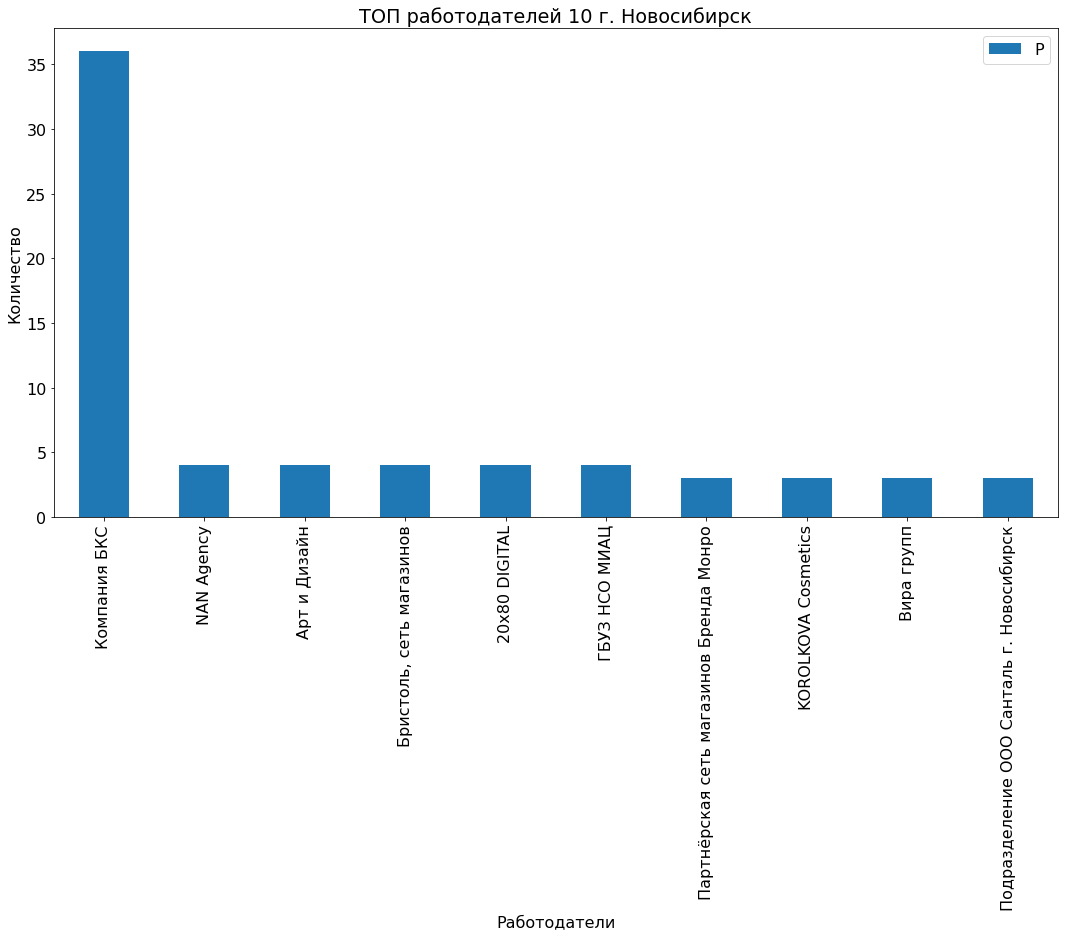

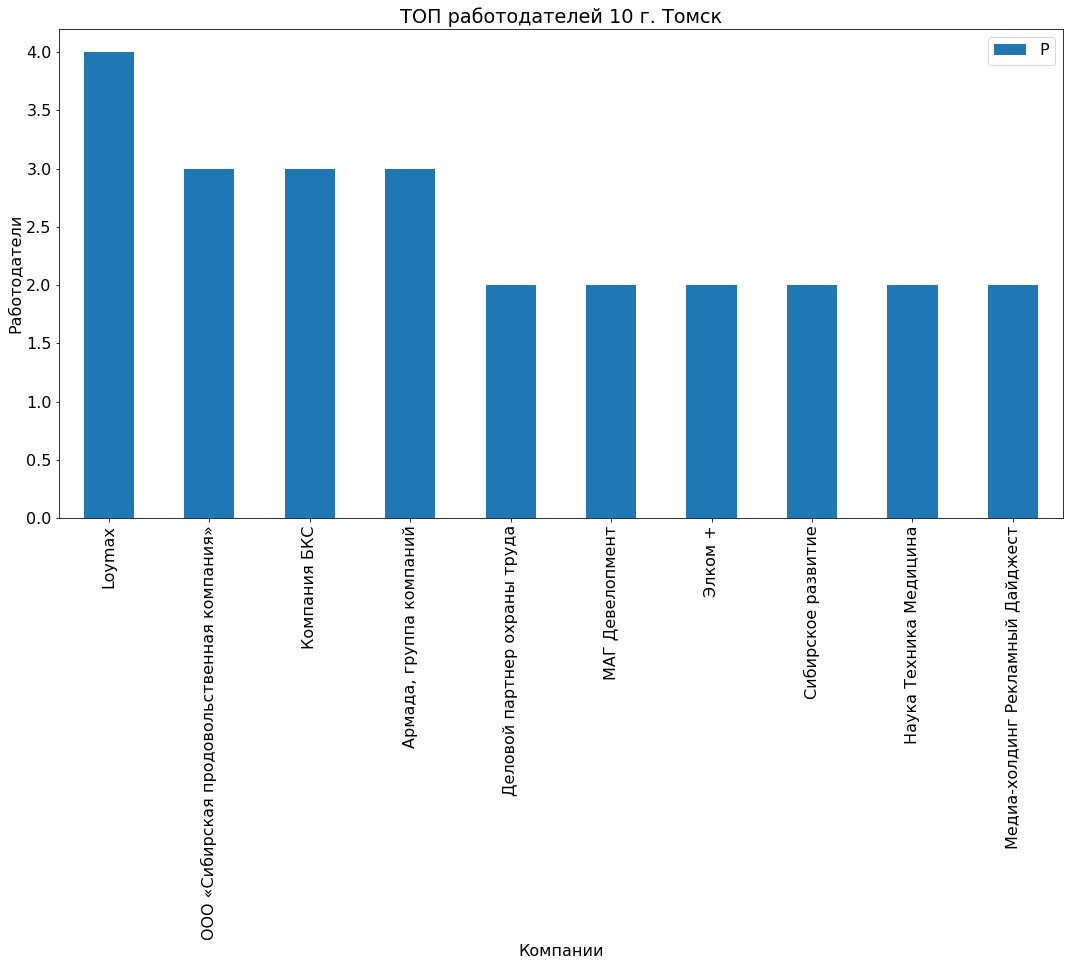

In [ ]:
plt.figure(figsize=(18, 9))
employers0 = data_NSK0.employer_name.value_counts()
employers0.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("ТОП работодателей 10 г. Новосибирск", color='black')
plt.xlabel('Работодатели')

plt.ylabel('Количество')
plt.legend('Работодатели')

plt.figure(figsize=(18, 9))
employers2 = data_TMK0.employer_name.value_counts()
employers2.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("ТОП работодателей 10 г. Томск", color='black')
plt.xlabel('Компании')

plt.ylabel('Работодатели')
plt.legend('Работодатели')

In [ ]:
employers0 = data_NSK0.employer_name.value_counts().sum()
employers0


299

In [ ]:
employers2 = data_TMK0.employer_name.value_counts().sum()
employers2

70

**ВЫВОД** 
В г. Новосибирске - 299 работодателей, в г. Томске 70. 

*  В г. Новосибирске лидирует работодатель - Компания БКС, однако не все ею предлагаемые вакансии удовлетворяют нашим запросам. Более интересны компании IT направленности: ГБУЗ НСО МИАЦ, NAN Agency, Арт и Дизайн, 20х80 DIGITAL.
В г. Томске нет явного лидера среди работодателей, отметим нескольких первых по запросам: Loymax,  Армада группа компаний, ООО «Сибирская продовольственная компания», Компания БКС.



  

In [ ]:
# в каком районе Новосибирска и Томска данная вакансия пользуется наибольшим спросом? А наименьшим?
# распределение спроса на вакансию по карте Новосибирска и Томска  (опционально)
#Строим карту России
russia_map = folium.Map(
    location = [57.23337810789467, 48.05744173358704],    # широта и долгота России
    zoom_start = 4,
    width = 1000,  
    height = 1000
)

#Накладываем на карту точки с адресами районов в которых представлены вакансии
heat_data = [[lat.replace('(','').replace("'",""), lon.replace(')','').replace(' ','').replace("'","")] for lat, lon in data['coord_district'].str.split(',') 
             if lat != None and lon != None] # готовим список координат

HeatMap(heat_data, radius=18, gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}).add_to(russia_map)

#Добавляем легенду
colormap = branca.colormap.LinearColormap(['blue', 'lime', 'red'], 
                                          vmin=1, 
                                          vmax=data['district'].value_counts()[0], 
                                          caption='Насыщение рынка по количеству вакансий')
colormap.add_to(russia_map)

russia_map




In [ ]:

data_NSK=data[(data['city']=='Новосибирск')]
#data_NSK.groupby(['city','district'])[['coord_district']].count().sort_values(by='coord_district', ascending=False)
data_NSK.groupby(['city','district'])[['coord_district']].count().sort_values(by='coord_district', ascending=False)

coord_district
city        district                                     
Новосибирск Железнодорожный район                      75
            Центральный район                          60
            Октябрьский район                          38
            Дзержинский район                          28
            Кировский район                            26
            Заельцовский район                         23
            Ленинский район                            21
            Академгородок,Советский район               8
            Калининский район                           7
            Первомайский район                          6
            Верхняя зона,Советский район                1
            Советский район                             1

In [ ]:
data_NSK.groupby(['city','district'])[['coord_district']].count().sort_values(by='coord_district', ascending=False).to_excel('районы Нск.xlsx')

In [ ]:
data_TMK=data[(data['city']=='Томск')]
data_TMK.groupby(['city','district'])[['coord_district']].count().sort_values(by='coord_district', ascending=False)

coord_district
city  district                                     
Томск Советский район                            32
      Кировский район                            14
      Ленинский район                            10
      Октябрьский район                           7
      Спичфабрика,Октябрьский район               3
      Черемошники,Ленинский район                 2
      Степановка,Кировский район                  1
      Степановка,Советский район                  1

In [ ]:
data_TMK.groupby(['city','district'])[['coord_district']].count().sort_values(by='coord_district', ascending=False).to_excel('районы Томск.xlsx')

**ВЫВОД** Анализ районов г. Новосибирска по распределению вакансий показывает, что  пользуется наибольшим спросом Аналитики пользуются в Железнодорожном и Центральном районах и наименьшим спросом - Первомайском и Советском районе.  
 Анализ районов г. Томска по распределению вакансий показывает, что  пользуется наибольшим спросом Аналитики пользуются в Советском и Кировском  районах и наименьшим спросом - Черемошники, (Ленинский район),  Степановка (Кировский район),   Степановка (Советский район).



In [ ]:
#распределение средней заработной платы по карте Новосибирска и Томска (опционально)
salary_mean  = (data
     .groupby(['city','district','coord_district'])[['salary_mean']]
     .mean()
)

russia_map = folium.Map(
    location = [57.23337810789467, 48.05744173358704],    # широта и долгота России
    zoom_start = 3,
    width = 1000,  
    height = 1000
)

heat_data = []
for i in range(len(salary_mean)):
  heat_data.append([salary_mean.index.values[i][2].split(',')[0].replace('(','').replace("'","")
, salary_mean.index.values[i][2].split(',')[1].replace(')','').replace("'","").replace(' ','')
, salary_mean['salary_mean'].values[i]])
#heat_data = heat_data.values.tolist()
HeatMap(heat_data, radius=18, gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}).add_to(russia_map)

colormap = branca.colormap.LinearColormap(['blue', 'lime', 'red'], 
                                          vmin=salary_mean['salary_mean'].min(), 
                                          vmax=salary_mean['salary_mean'].max(), 
                                          caption='Насыщение рынка по средней предлагаемой зарплате')
colormap.add_to(russia_map)

russia_map


**ВЫВОД** 

Ожидаемо в г. Новосибирске средняя заработная плата выше , чем в Томске.
Наиболее высокие зарплаты находится в центральной части города Новосибирска, тогда как в  г. Томске наблюдается сосредоточение высоких зарплат более отдаленных районах от центра города.





**3. Анализ профессии, о которой вы мечтали в детстве**

Проведите аналогичный research для профессии, о которой вы мечтали в детстве. Это может быть повар, учитель, пожарный и тд - все зависит от вас :)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving da_hh_sibir3.csv to da_hh_sibir3.csv


In [ ]:
# читаем файл csv
data2 = pd.read_csv("da_hh_sibir3.csv", encoding='utf8', index_col=0)
data2['professional_roles'] = data2['professional_roles'].str.rstrip(', ')
data2['skills_name'] = data2['skills_name'].str.rstrip(', ')
data2

,name,skills_name,professional_roles,expirience_name,department_name,area_name,salary_from,salary_to,salary_currency,type_name,...,working_days,working_time_intervals,working_time_modes,city,street,building,metro,district,coord_district,lat_district
0,Водитель-курьер на личном автомобиле,"Грамотная речь, Грамотность, Водительское удос...",Водитель,Нет опыта,NaN,Владивосток,80000.0,106000.0,RUR,Открытая,...,[],[],[],Владивосток,Днепровская улица,27с2,NaN,Первореченский район,"('43.132644', '131.9071984')",43.132644
3,"Водитель-курьер (подарки, ценности, легкие пос...","Driving Licence B, Водительское удостоверение ...",Курьер,Нет опыта,NaN,Владивосток,70000.0,120000.0,RUR,Открытая,...,"[{'id': 'only_saturday_and_sunday', 'name': 'Р...","[{'id': 'from_four_to_six_hours_in_a_day', 'na...","[{'id': 'start_after_sixteen', 'name': 'Можно ...",Владивосток,проспект 100-летия Владивостока,46,NaN,Первореченский район,"('43.132644', '131.9071984')",43.132644
4,Водитель,"Желание Работать ,спокойный подход к работе , ...",Водитель,От 1 года до 3 лет,NaN,Владивосток,120000.0,120000.0,RUR,Открытая,...,[],[],[],Владивосток,NaN,NaN,NaN,NaN,"('43.1150678', '131.8855768')",43.115068
6,Водитель-экспедитор,NaN,Водитель,От 1 года до 3 лет,NaN,Владивосток,68000.0,68000.0,RUR,Открытая,...,[],[],[],Владивосток,Карьерная улица,20А,NaN,Первореченский район,"('43.132644', '131.9071984')",43.132644
9,Водитель-экспедитор,"Автомобильные перевозки, Водительское удостове...",Водитель,От 3 до 6 лет,NaN,Владивосток,90000.0,130000.0,RUR,Открытая,...,[],[],[],Владивосток,Командорская улица,11,NaN,Ленинский район,"('43.12367635', '131.98346945617897')",43.123676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,Заведующий автохозяйством,NaN,Другое,От 3 до 6 лет,NaN,Владивосток,66000.0,66000.0,RUR,Открытая,...,[],[],[],Владивосток,Бородинская улица,14,NaN,Первореченский район,"('43.132644', '131.9071984')",43.132644
221,Инспектор ДПС (дорожно-патрульной службы),"Терпеливость, Грамотная речь, Работа с докумен...",Другое,Нет опыта,NaN,Владивосток,40000.0,60000.0,RUR,Открытая,...,[],[],[],Владивосток,Фонтанная улица,10,NaN,Фрунзенский район,"('43.18063755', '131.7447792577687')",43.180638
223,Машинист паровой передвижной депарафинизирован...,NaN,Машинист,От 3 до 6 лет,NaN,Владивосток,120000.0,120000.0,RUR,Открытая,...,[],[],[],Владивосток,NaN,63,NaN,Гарнизонна фурна,"('42.1357624', '24.7208446')",42.135762
233,Инспектор дорожно-патрульной службы (Инспектор...,NaN,Полицейский,Нет опыта,NaN,Владивосток,35000.0,60000.0,RUR,Открытая,...,[],[],[],Владивосток,Фонтанная улица,10,NaN,Фрунзенский район,"('43.18063755', '131.7447792577687')",43.180638


In [ ]:
# в каком районе Владивостока данная вакансия пользуется наибольшим спросом? А наименьшим?
# распределение спроса на вакансию по карте Владивостока (опционально)
#Строим карту России
russia_map = folium.Map(
    location = [57.23337810789467, 48.05744173358704],    # широта и долгота России
    zoom_start = 4,
    width = 1000,  
    height = 1000
)

#Накладываем на карту точки с адресами районов в которых представлены вакансии
heat_data = [[lat.replace('(','').replace("'",""), lon.replace(')','').replace(' ','').replace("'","")] for lat, lon in data2['coord_district'].str.split(',') 
             if lat != None and lon != None]

HeatMap(heat_data, radius=18, gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}).add_to(russia_map)

#Добавляем легенду
colormap = branca.colormap.LinearColormap(['blue', 'lime', 'red'], 
                                          vmin=1, 
                                          vmax=data2['district'].value_counts()[0], 
                                          caption='Насыщение рынка по количеству вакансий')
colormap.add_to(russia_map)

russia_map


In [ ]:
data2['salary_mean'] = round((data2['salary_from'] + data2['salary_to']) / 2)
data2.head(5)

,name,skills_name,professional_roles,expirience_name,department_name,area_name,salary_from,salary_to,salary_currency,type_name,...,working_time_intervals,working_time_modes,city,street,building,metro,district,coord_district,lat_district,salary_mean
0,Водитель-курьер на личном автомобиле,"Грамотная речь, Грамотность, Водительское удос...",Водитель,Нет опыта,NaN,Владивосток,80000.0,106000.0,RUR,Открытая,...,[],[],Владивосток,Днепровская улица,27с2,NaN,Первореченский район,"('43.132644', '131.9071984')",43.132644,93000.0
3,"Водитель-курьер (подарки, ценности, легкие пос...","Driving Licence B, Водительское удостоверение ...",Курьер,Нет опыта,NaN,Владивосток,70000.0,120000.0,RUR,Открытая,...,"[{'id': 'from_four_to_six_hours_in_a_day', 'na...","[{'id': 'start_after_sixteen', 'name': 'Можно ...",Владивосток,проспект 100-летия Владивостока,46,NaN,Первореченский район,"('43.132644', '131.9071984')",43.132644,95000.0
4,Водитель,"Желание Работать ,спокойный подход к работе , ...",Водитель,От 1 года до 3 лет,NaN,Владивосток,120000.0,120000.0,RUR,Открытая,...,[],[],Владивосток,NaN,NaN,NaN,NaN,"('43.1150678', '131.8855768')",43.115068,120000.0
6,Водитель-экспедитор,NaN,Водитель,От 1 года до 3 лет,NaN,Владивосток,68000.0,68000.0,RUR,Открытая,...,[],[],Владивосток,Карьерная улица,20А,NaN,Первореченский район,"('43.132644', '131.9071984')",43.132644,68000.0
9,Водитель-экспедитор,"Автомобильные перевозки, Водительское удостове...",Водитель,От 3 до 6 лет,NaN,Владивосток,90000.0,130000.0,RUR,Открытая,...,[],[],Владивосток,Командорская улица,11,NaN,Ленинский район,"('43.12367635', '131.98346945617897')",43.123676,110000.0


In [ ]:
#распределение средней заработной платы по карте Новосибирска и Томска (опционально)

salary_mean  = (data2
     .groupby(['city','district','coord_district'])[['salary_mean']]
     .mean()
)

russia_map = folium.Map(
    location = [57.23337810789467, 48.05744173358704],    # широта и долгота России
    zoom_start = 3,
    width = 1000,  
    height = 1000
)

heat_data = []
for i in range(len(salary_mean)):
  heat_data.append([salary_mean.index.values[i][2].split(',')[0].replace('(','').replace("'","")
, salary_mean.index.values[i][2].split(',')[1].replace(')','').replace("'","").replace(' ','')
, salary_mean['salary_mean'].values[i]])

HeatMap(heat_data, radius=18, gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}).add_to(russia_map)

colormap = branca.colormap.LinearColormap(['blue', 'lime', 'red'], 
                                          vmin=salary_mean['salary_mean'].min(), 
                                          vmax=salary_mean['salary_mean'].max(), 
                                          caption='Насыщение рынка по средней предлагаемой зарплате')
colormap.add_to(russia_map)

russia_map